<a href="https://colab.research.google.com/github/kingsleyyeon/PrecisionMatEst/blob/main/PrecisionMatCholesky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimize by column using Cholesky (for banded matrices)

In [ ]:
import numpy as np
import pandas as pd

def newton_cholesky_band_corrected(X, m, n, max_iter=100, tol=1e-8):
    """
    Estimate the banded Cholesky factor L (with nonzeros only on the diagonal and subdiagonal)
    from data X using Newton's method applied column by column.

    For each column j, we optimize the loss
      f_j(z) = -m*log(z[0]) + (1/2)*sum_{i=1}^m ( u_i[j:j+d] dot z )^2, z[0] correspond to Ljj diagonal entry of L.
    where d = min(2, n-j) and z = L[j:j+d, j].

    This loss corresponds to the Gaussian negative log-likelihood
    when the precision matrix is given by P = L L^T.

    Parameters:
      X       : (m x n) data matrix (each row is a sample)
      m       : number of samples
      n       : dimension of the data (L is n x n)
      max_iter: maximum number of Newton iterations per column
      tol     : tolerance for the Newton step

    Returns:
      L       : estimated lower-triangular Cholesky factor (n x n), banded with bandwidth 2.
    """
    L = np.zeros((n, n))

    # Initialize L: set diagonal to 1 and the off-diagonal in the band to 0.
    for j in range(n):
        L[j, j] = 1.0

    # Process each column j
    for j in range(n):
        print('column:',j)
        # For a tridiagonal L, only positions j and (if exists) j+1 are free.
        d = min(2, n - j)       # we know sparsity pattern of L for tridiagonal
        z = L[j:j+d, j].copy()  # current free parameters in column j, shape (d,)
        print('z init:',z)
        # Only the corresponding entries in X are needed.
        X_band = X[:, j:j+d]    # shape (m, d)

        # Newton iterations for column j.
        for it in range(max_iter):
            # Compute predictions: for each sample i, r_i = X_band[i] dot z.
            r = X_band.dot(z)  # shape (m,)

            # Compute gradient.
            # Derivative of -m*log(z[0]) is -m/z[0] (only affecting the first element/diagonal).
            # Derivative of (1/2)*sum_i (r_i)^2 is X_band.T dot r.
            g = np.zeros(d)
            g[0] = -m / z[0]
            g += X_band.T.dot(r)

            # Compute Hessian.
            # Hessian from quadratic term: X_band.T dot X_band.
            H = X_band.T.dot(X_band)
            # Hessian from -log term: only the (0,0) entry gets m/(z[0]^2).
            H[0, 0] += m / (z[0]**2)

            # Solve for the Newton step: H * delta = -g.
            delta = np.linalg.solve(H, -g)
            z = z + delta
            print('z:',z)

            if np.linalg.norm(delta) < tol:
                break

        # Update column j of L.
        L[j:j+d, j] = z
    return L

def compute_cholesky_estimate_corrected():
    np.random.seed(0)
    n = 5       # dimension
    m = 1000    # number of samples

    # Construct a tridiagonal precision matrix P = 2I - off-diagonals (-1).
    P = 2 * np.eye(n)
    for i in range(n - 1):
        P[i, i+1] = -1
        P[i+1, i] = -1

    # Compute the true Cholesky factor L_true via numpy.
    L_true = np.linalg.cholesky(P)
    # Covariance is the inverse of the precision.
    Sigma = np.linalg.inv(P)

    # Generate m samples from N(0, Sigma).
    X = np.random.multivariate_normal(np.zeros(n), Sigma, size=m)

    # Estimate L using the corrected Newton method.
    L_est = newton_cholesky_band_corrected(X, m, n)

    frob_error = np.linalg.norm(L_true - L_est, ord='fro')
    return L_true, L_est, frob_error

# Run the computation and save the results.
L_true, L_est, frob_error = compute_cholesky_estimate_corrected()

print("True L (from np.linalg.cholesky):\n", L_true)
print("\nEstimated L (via Newton's method):\n", L_est)
print("\nFrobenius norm error between L_true and L_est: {:.2e}".format(frob_error))

# For additional verification, check that L_true@L_true.T equals the precision matrix,
# and compare it with  L_est@L_est.T.
print("\nTrue precision matrix (L_true @ L_true.T):\n", L_true @ L_true.T)
print("\nEstimated precision matrix (L_est @ L_est.T):\n", L_est @ L_est.T)


column: 0
z init: [1. 0.]
z: [ 1.32093908 -0.63124629]
z: [ 1.39266252 -0.66552127]
z: [ 1.39471847 -0.66650376]
z: [ 1.39471999 -0.66650448]
z: [ 1.39471999 -0.66650448]
column: 1
z init: [1. 0.]
z: [ 1.21518669 -0.78941306]
z: [ 1.24398832 -0.80812326]
z: [ 1.24433783 -0.80835031]
z: [ 1.24433788 -0.80835034]
z: [ 1.24433788 -0.80835034]
column: 2
z init: [1. 0.]
z: [ 1.17416608 -0.91990232]
z: [ 1.19224882 -0.93406926]
z: [ 1.19239022 -0.93418005]
z: [ 1.19239023 -0.93418005]
z: [ 1.19239023 -0.93418005]
column: 3
z init: [1. 0.]
z: [ 1.14184116 -0.91179282]
z: [ 1.15344418 -0.92105817]
z: [ 1.15350373 -0.92110572]
z: [ 1.15350374 -0.92110573]
column: 4
z init: [1.]
z: [1.10212883]
z: [1.10790673]
z: [1.10792196]
z: [1.10792196]
True L (from np.linalg.cholesky):
 [[ 1.41421356  0.          0.          0.          0.        ]
 [-0.70710678  1.22474487  0.          0.          0.        ]
 [ 0.         -0.81649658  1.15470054  0.          0.        ]
 [ 0.          0.         -0.86602

## Estimate the sparsity pattern of Gaussian kernel (sigma=2), almost tridiagonal

Constraints satisfied for complexity 1: True

Constraints satisfied for complexity 2: True

Constraints satisfied for complexity 3: True

Constraints satisfied for complexity 4: True

Constraints satisfied for complexity 5: True

Constraints satisfied for complexity 6: True

Constraints satisfied for complexity 7: True

Constraints satisfied for complexity 8: True

Constraints satisfied for complexity 9: True

Constraints satisfied for complexity 10: True

Constraints satisfied for complexity 11: True

Constraints satisfied for complexity 12: True

Constraints satisfied for complexity 13: True

Constraints satisfied for complexity 14: True

Constraints satisfied for complexity 15: True



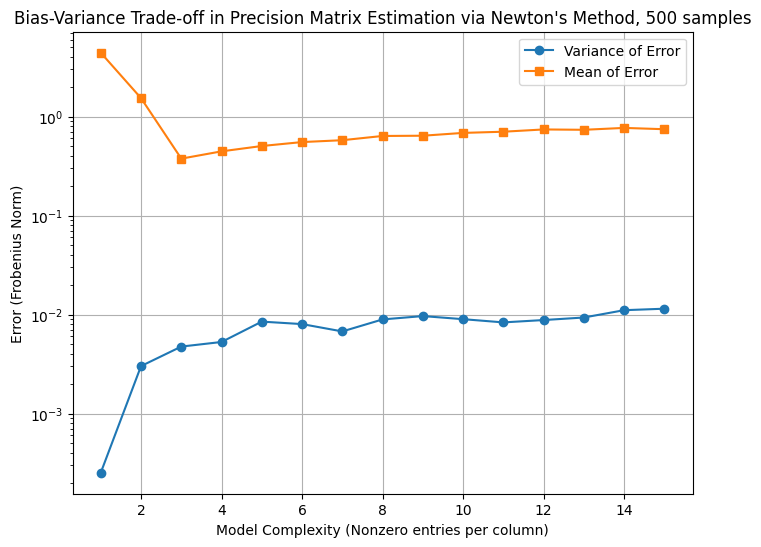

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_kernel_matrix(n, sigma=2.0):
    """
    Generate a Gaussian kernel matrix (which is positive definite)
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness (shift if necessary)
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_cholesky_sparse(Y, m, n, k, max_iter=100, tol=1e-8):
    """
    Estimate the lower-triangular Cholesky factor L of the precision matrix Theta = L L^T,
    subject to a sparsity pattern that allows at most k nonzero entries per column.

    Here, the loss for column j is:
       f_j(z) = -m*log(z[0]) + (1/2)*sum_{i=1}^m ( Y[i, j:j+d] dot z )^2,
    where d = min(k, n - j) and z = L[j:j+d, j]. The samples Y are drawn from N(0, Sigma)
    with Sigma = Theta_true^{-1}.

    Parameters:
      Y       : (m x n) data matrix (each row is a sample)
      m       : number of samples
      n       : ambient dimension (L is n x n)
      k       : complexity; number of nonzero entries allowed per column in L.
      max_iter: maximum Newton iterations per column.
      tol     : tolerance for convergence.

    Returns:
      L       : estimated lower-triangular Cholesky factor (n x n), with sparsity pattern:
                for each column j, only rows j,...,min(n-1, j+k-1) may be nonzero.
    """
    L = np.zeros((n, n))
    # Initialize L: set diagonal to 1; other allowed entries start at 0.
    for j in range(n):
        L[j, j] = 1.0

    # Process each column j
    for j in range(n):
        d = min(k, n - j)  # number of free parameters in column j, *k is the max number of non-zero parameters
        # The free part of column j
        z = L[j:j+d, j].copy()  # shape (d,)
        # Use only the corresponding columns of Y
        Y_band = Y[:, j:j+d]     # shape (m, d)

        for it in range(max_iter):
            # Prediction: for each sample i, compute r_i = Y_band[i] dot z.
            r = Y_band.dot(z)  # shape (m,)
            # Loss: f(z) = -m log(z[0]) + (1/2)*sum_i r_i^2.
            # Gradient:
            #   For the first element: -m/z[0] + (Y_band^T r)[0],
            #   For others: (Y_band^T r)[k].
            g = np.zeros(d)
            g[0] = -m / z[0]
            g += Y_band.T.dot(r)
            # Hessian: from quadratic part: Y_band^T Y_band;
            # from -log: add m/(z[0]^2) to (0,0) element.
            H = Y_band.T.dot(Y_band)
            H[0, 0] += m / (z[0]**2)

            # Newton step: solve H * delta = -g.
            delta = np.linalg.solve(H, -g)
            z = z + delta

            if np.linalg.norm(delta) < tol:
                break

        L[j:j+d, j] = z
    return L

# --- Experiment setup ---
n = 15  # matrix dimension
# Generate a "true" precision matrix from a Gaussian kernel.
true_theta = generate_kernel_matrix(n, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 500   # number of samples per trial
complexities = range(1, n + 1)  # allow k = 1, 2, ..., n nonzero entries per column

variance_list = []
mean_error_list = []

# We'll also save the last estimated Theta for each complexity.
Theta_est_dict = {}

for k in complexities:
    errors = []
    # For our Newton method, the allowed sparsity pattern for L is:
    # for each column j, allowed rows: j, j+1, ..., min(n-1, j+k-1).
    # (Entries not in this block remain zero.)
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        # Estimate the Cholesky factor L (with the given complexity k)
        L_est = newton_cholesky_sparse(Y, m, n, k)
        # Form the estimated precision: Theta_est = L_est @ L_est^T.
        Theta_est = L_est @ L_est.T
        error = np.linalg.norm(Theta_est - true_theta, 'fro')
        errors.append(error)
    Theta_est_dict[k] = Theta_est  # save last estimate for this k
    mean_error_list.append(np.mean(errors))
    variance_list.append(np.var(errors))

    # Also print the estimated Theta for this complexity as a DataFrame.
    Theta_est_df = pd.DataFrame(Theta_est,
                                columns=[f"Col {i}" for i in range(n)],
                                index=[f"Row {i}" for i in range(n)])
    # print(f"\nTheta_est for complexity {k} nonzero entries per column:\n")
    # print(Theta_est_df)

    # Check that the estimated L respects our sparsity pattern.
    valid = True
    for j in range(n):
        allowed = set(range(j, min(n, j+k)))
        for i in range(n):
            if i not in allowed and abs(L_est[i, j]) > 1e-8:
                valid = False
                break
        if not valid:
            break
    print(f"Constraints satisfied for complexity {k}: {valid}\n")

# Plot the mean and variance of the errors.
plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per column)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation via Newton's Method, 500 samples")
plt.legend()
plt.grid(True)
plt.show()

# print("true_theta =\n", pd.DataFrame(true_theta))


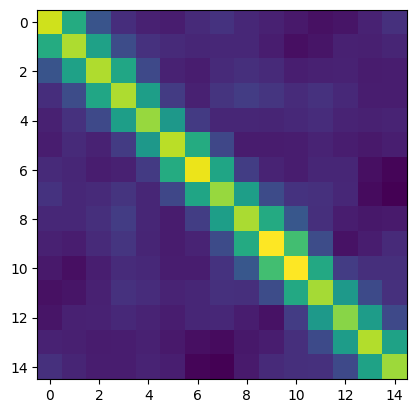

In [ ]:
plt.imshow(Theta_est_dict[15])

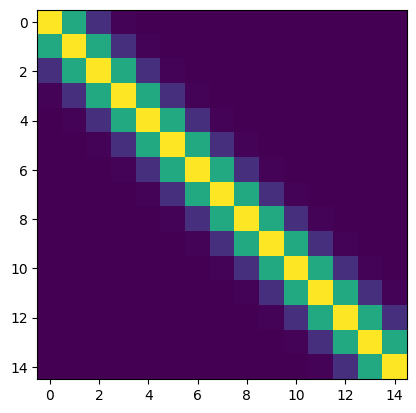

In [ ]:
plt.imshow(true_theta)

## Delta theorem check

Predicted asymptotic variances (diagonals): [0.31606028 0.76412835 0.9867958  0.99990581 0.99999991 1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


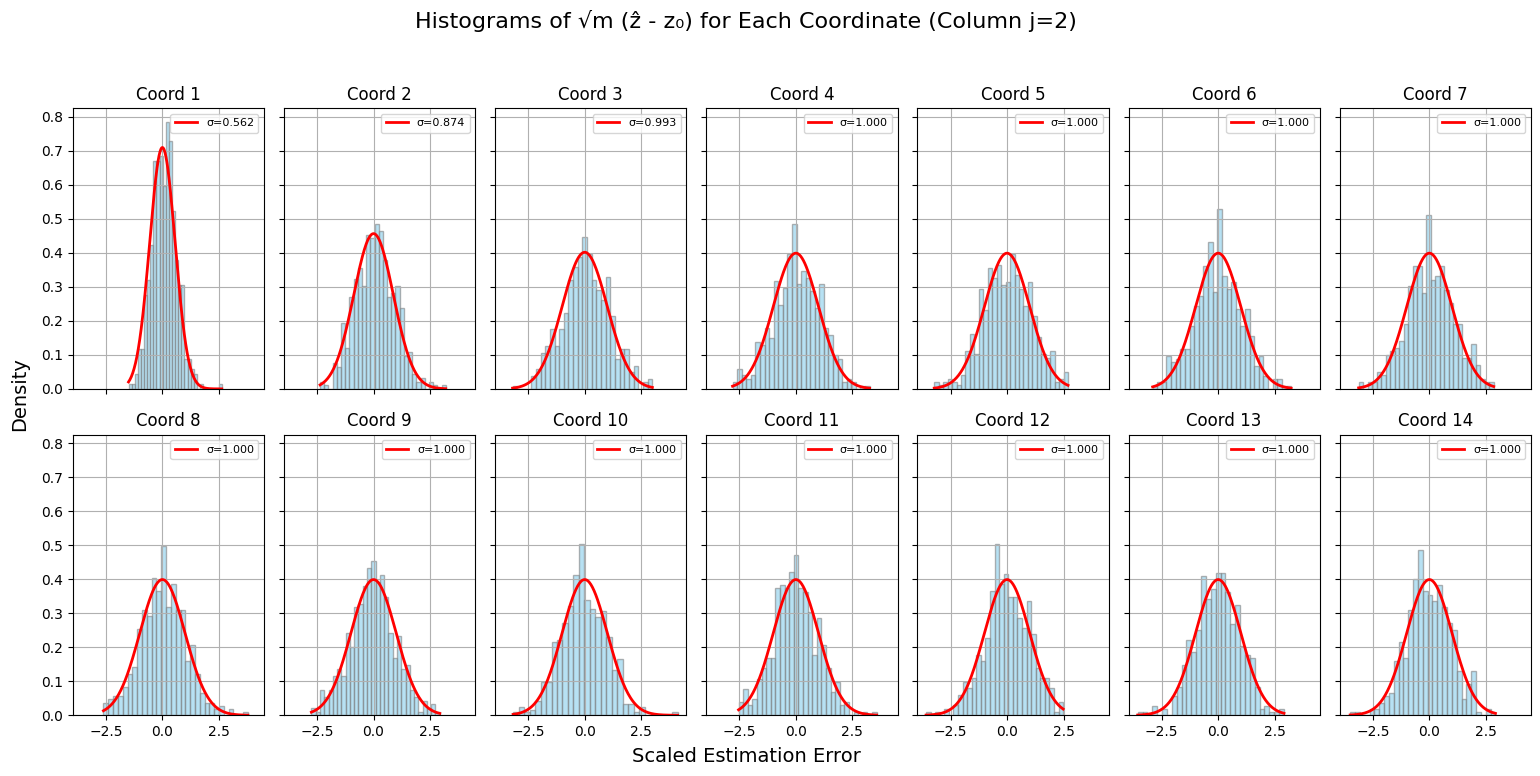

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# Helper: Generate a positive-definite Gaussian kernel matrix.
def generate_kernel_matrix(n, sigma=2.0):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

# Newton update for estimating the j-th column (free parameters from index j onward)
def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    d = n - j  # number of free parameters in column j
    z = np.zeros(d)
    z[0] = 1.0  # initialize the diagonal parameter to 1
    for it in range(max_iter):
        Y_band = Y[:, j:n]  # use entries from index j to n for each sample
        r = Y_band.dot(z)   # prediction vector, shape (m,)
        # Gradient: first element gets -m/z[0] plus (Y_band^T r); rest are given by Y_band^T r.
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        # Hessian: from the quadratic term plus the -log term for the first element.
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0]**2)
        delta = np.linalg.solve(H, -g)
        z = z + delta
        if np.linalg.norm(delta) < tol:
            break
    return z

# Simulation parameters
n = 15          # Dimension of the precision matrix.
m = 10000       # Sample size per trial.
num_trials = 500  # Number of Monte Carlo replications.
j = 1           # We focus on the 2nd column (0-indexed j=1).

# Generate true precision matrix and its Cholesky factor.
true_theta = generate_kernel_matrix(n, sigma=2.0)
L_true = np.linalg.cholesky(true_theta)
Sigma = np.linalg.inv(true_theta)

# For the chosen column j, the free parameters are z = L[j:n, j].
z0 = L_true[j:n, j].copy()  # true parameter vector (dimension d = n-j)
d = n - j

# The theoretical per-observation Hessian is:
#   H_asy = Sigma_sub + (1 / L_true[j,j]^2) * (e1 e1^T)
Sigma_sub = Sigma[j:n, j:n]
e1 = np.zeros(d)
e1[0] = 1.0
H_asy = Sigma_sub + (1 / (L_true[j, j]**2)) * np.outer(e1, e1)
# Asymptotic covariance for sqrt(m)*(hat{z} - z0) is V_pred = H_asy^{-1}.
V_pred = np.linalg.inv(H_asy)
print("Predicted asymptotic variances (diagonals):", np.diag(V_pred))

# Monte Carlo simulation: collect sqrt(m)*(hat{z} - z0) for each trial.
diffs = np.zeros((num_trials, d))
for trial in range(num_trials):
    Y = np.random.multivariate_normal(np.zeros(n), Sigma, size=m)
    z_hat = newton_column(Y, m, j, n)
    diffs[trial, :] = np.sqrt(m) * (z_hat - z0)

# Plot histograms for each coordinate in a 2x7 grid.
fig, axs = plt.subplots(2, 7, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.flatten()

for idx in range(d):
    data = diffs[:, idx]
    sigma_theory = np.sqrt(V_pred[idx, idx])
    ax = axs[idx]
    # Plot histogram of empirical scaled error
    counts, bins, _ = ax.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
    # Overlay the theoretical density curve.
    x = np.linspace(bins[0], bins[-1], 200)
    y = norm.pdf(x, loc=0, scale=sigma_theory)
    ax.plot(x, y, 'r-', lw=2, label=f'σ={sigma_theory:.3f}')
    ax.set_title(f'Coord {idx+1}')
    ax.legend(fontsize=8)
    ax.grid(True)

# Remove empty subplots if d < 14.
for idx in range(d, 14):
    fig.delaxes(axs[idx])

fig.suptitle('Histograms of √m (ẑ - z₀) for Each Coordinate (Column j=2)', fontsize=16)
fig.text(0.5, 0.04, 'Scaled Estimation Error', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("cholesky_asymptotics.png", dpi=300)
plt.show()


In [ ]:
np.sqrt(np.diag(V_pred))

array([0.56219239, 0.87414435, 0.99337596, 0.99995291, 0.99999996,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

##KL divergence of $(LL^T)^{-1}$ and $\Sigma$

In [ ]:
import numpy as np

def generate_kernel_matrix(n, sigma=2.0):
    """
    Generate a positive-definite n x n kernel matrix using a Gaussian kernel.
    """
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    """
    Estimate the j-th column (rows j:n) of the Cholesky factor using Newton's method.
    """
    d = n - j
    z = np.zeros(d)
    z[0] = 1.0  # initialize the diagonal
    for _ in range(max_iter):
        Y_band = Y[:, j:n]  # Only the relevant columns
        r = Y_band.dot(z)
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0] ** 2)
        delta = np.linalg.solve(H, -g)
        z += delta
        if np.linalg.norm(delta) < tol:
            break
    return z

def estimate_cholesky(Y, m, n):
    """
    Estimate the full lower-triangular Cholesky factor L column-by-column.
    """
    L_est = np.zeros((n, n))
    for j in range(n):
        z = newton_column(Y, m, j, n)
        L_est[j:, j] = z
    return L_est

def A_mv(v, Sigma, L_est):
    """
    Given a vector v, compute A*v = L_est^T [ Sigma (L_est * v) ].
    This requires exactly one mat-vec with Sigma.
    """
    return L_est.T @ (Sigma @ (L_est @ v))

def lanczos(A_mv_func, v, k, Sigma, L_est):
    """
    Run the scalar Lanczos algorithm for k steps on the symmetric operator A (via A_mv_func).
    Returns the k x k tridiagonal matrix T.
    """
    n = len(v)
    Q = np.zeros((n, k))
    alpha = np.zeros(k)
    beta = np.zeros(k + 1)
    Q[:, 0] = v
    for j in range(k):
        w = A_mv_func(Q[:, j], Sigma, L_est)
        if j > 0:
            w -= beta[j] * Q[:, j - 1]
        alpha[j] = np.dot(Q[:, j], w)
        w -= alpha[j] * Q[:, j]
        beta[j + 1] = np.linalg.norm(w)
        if beta[j + 1] < 1e-12 or j == k - 1:
            k_actual = j + 1
            alpha = alpha[:k_actual]
            beta = beta[:k_actual + 1]
            Q = Q[:, :k_actual]
            break
        Q[:, j + 1] = w / beta[j + 1]
        k_actual = k
    # Construct the tridiagonal T from alpha and beta[1:k_actual]
    T = np.diag(alpha)
    for i in range(k_actual - 1):
        T[i, i + 1] = beta[i + 1]
        T[i + 1, i] = beta[i + 1]
    return T

def randomized_kl_divergence(Sigma, L_est, num_probes=10, lanczos_steps=20):
    """
    Estimate the KL divergence using a scalar stochastic Lanczos quadrature (SLQ) method.
    f(lambda) = lambda - log(lambda) - 1, and KL = 0.5 * trace(f(A)),
    where A = L_est^T Sigma L_est.
    Each probe uses one random vector and lanczos_steps mat-vecs with Sigma.
    """
    def f(x):
        return x - np.log(x) - 1.0

    n = L_est.shape[0]
    estimates = []
    for _ in range(num_probes):
        # Use a Rademacher random vector and normalize it.
        z = np.random.choice([-1, 1], size=n).astype(np.float64)
        v = z / np.linalg.norm(z)
        # Run scalar Lanczos on A (implicitly defined by A_mv)
        T = lanczos(A_mv, v, lanczos_steps, Sigma, L_est)
        # Diagonalize T to get its eigenvalues and eigenvectors.
        eigvals, U_eig = np.linalg.eigh(T)
        # Quadrature approximation: for scalar SLQ, the estimate is e_1^T f(T) e_1.
        # With a normalized starting vector, the estimate for trace(f(A)) is n * (e_1^T f(T) e_1).
        estimate = n * np.sum((U_eig[0, :] ** 2) * f(eigvals))
        estimates.append(estimate)
    trace_estimate = np.mean(estimates)
    return 0.5 * trace_estimate

# --- Block Monte Carlo (Blocked SLQ) Implementation ---

def A_mv_block(V, Sigma, L_est):
    """
    Apply the operator A to a block V.
    V is an n x k matrix.
    """
    return L_est.T @ (Sigma @ (L_est @ V))

def block_lanczos(A_mv_block_func, U, m, Sigma, L_est):
    """
    Run the block Lanczos algorithm for m iterations.

    Input:
      U  : initial n x k block with orthonormal columns.
      m  : number of Lanczos iterations.

    Returns:
      T  : block tridiagonal Jacobi matrix of size (m*k) x (m*k).
    """
    n, k = U.shape
    P_blocks = []    # list to store P_i (n x k)
    A_blocks = []    # list to store A_i (k x k) blocks on diagonal.
    B_blocks = []    # list to store B_{i+1} (k x k) off-diagonal blocks.

    P_blocks.append(U)
    # For convenience, set P_{-1} = 0.
    P_prev = np.zeros_like(U)

    for i in range(m):
        # Apply operator to current block.
        W = A_mv_block_func(P_blocks[i], Sigma, L_est)
        if i > 0:
            W = W - P_blocks[i-1] @ B_blocks[i-1].T
        # Compute the block diagonal coefficient.
        A_i = P_blocks[i].T @ W
        A_blocks.append(A_i)
        # Subtract the projection on P_i.
        W = W - P_blocks[i] @ A_i
        # (Optionally reorthogonalize W here.)
        # Compute the QR factorization of W.
        Q, R = np.linalg.qr(W)
        # Check for breakdown (rank deficiency).
        if np.linalg.norm(R) < 1e-12:
            break
        B_blocks.append(R)
        P_blocks.append(Q)

    m_actual = len(A_blocks)
    T_dim = m_actual * k
    T = np.zeros((T_dim, T_dim))
    for i in range(m_actual):
        T[i*k:(i+1)*k, i*k:(i+1)*k] = A_blocks[i]
        if i < m_actual - 1:
            T[i*k:(i+1)*k, (i+1)*k:(i+2)*k] = B_blocks[i]
            T[(i+1)*k:(i+2)*k, i*k:(i+1)*k] = B_blocks[i].T
    return T

def randomized_kl_divergence_block(Sigma, L_est, num_probes, lanczos_steps, block_size):
    """
    Estimate the KL divergence using a block stochastic Lanczos quadrature method.

    For each block probe, we generate an n x block_size random matrix with Rademacher entries,
    orthonormalize its columns, and run a block Lanczos algorithm to build the block tridiagonal
    Jacobi matrix T. Then we compute the quadrature rule from the eigen-decomposition of T.

    The quadrature estimate for trace(U^T f(A) U) is given by:
      sum_{j} (w_j f(mu_j)),
    where the weights w_j are the squared norms of the first block of rows (of size block_size)
    of the eigenvector matrix.

    An unbiased estimator for trace(f(A)) is then given by (n/block_size) times this quadrature sum.
    Finally, the KL divergence is estimated as 0.5 * trace(f(A)).
    """
    def f(x):
        return x - np.log(x) - 1.0

    n = L_est.shape[0]
    estimates = []
    for _ in range(num_probes):
        # Generate an n x block_size random matrix with Rademacher entries.
        Z = np.random.choice([-1, 1], size=(n, block_size)).astype(np.float64)
        # Orthonormalize its columns.
        Q, _ = np.linalg.qr(Z)
        # Run block Lanczos for lanczos_steps iterations.
        T = block_lanczos(A_mv_block, Q, lanczos_steps, Sigma, L_est)
        # Diagonalize T.
        eigvals, Q_T = np.linalg.eigh(T)
        # The first block of Q_T (rows 0 to block_size-1) yields the quadrature weights.
        weights = np.sum(Q_T[0:block_size, :]**2, axis=0)  # weights sum to block_size.
        # Quadrature estimate for trace(Q^T f(A) Q) is:
        quad_estimate = np.sum(weights * f(eigvals))
        # Unbias the estimator: since E[trace(Q^T f(A) Q)] = (block_size/n)*trace(f(A)),
        # multiply by (n/block_size).
        estimates.append((n / block_size) * quad_estimate)
    trace_estimate = np.mean(estimates)
    return 0.5 * trace_estimate

def kl_divergence_direct(Sigma, L_est):
    """
    Directly compute the KL divergence via
    KL = 0.5 * [ trace(L_est L_est^T Sigma) - logdet(L_est L_est^T Sigma) - n ].
    """
    n = Sigma.shape[0]
    M = L_est @ L_est.T @ Sigma
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * (np.trace(M) - logdet - n)

# ---------------------------
# Main Simulation
# ---------------------------
np.random.seed(42)
n = 200
m_samples = 10000

# Generate covariance matrix Sigma and samples Y ~ N(0, Sigma)
Sigma = generate_kernel_matrix(n, sigma=2.0)
mean = np.zeros(n)
Y = np.random.multivariate_normal(mean, Sigma, size=m_samples)

# Estimate Cholesky factor L_est from data
L_est = estimate_cholesky(Y, m_samples, n)

# Compute KL divergence using direct (full-matrix) computation
kl_direct = kl_divergence_direct(Sigma, L_est)

# Estimate KL divergence via scalar randomized SLQ
kl_randomized = randomized_kl_divergence(Sigma, L_est, num_probes=20, lanczos_steps=30)

# Estimate KL divergence via block Monte Carlo (blocked SLQ)
kl_randomized_block = randomized_kl_divergence_block(Sigma, L_est, num_probes=20,
                                                     lanczos_steps=30, block_size=5)

print("KL divergence (direct computation):", kl_direct)
print("KL divergence (randomized SLQ, scalar):", kl_randomized)
print("KL divergence (randomized SLQ, block):", kl_randomized_block)


KL divergence (direct computation): 1.0449837860731321
KL divergence (randomized SLQ, scalar): 1.0329911574545187
KL divergence (randomized SLQ, block): 1.0324964146417577


True trace of f(A): 2.0899675721462696
Empirical mean: 2.0894406822998097
Empirical variance: 0.008906076294502196
Empirical std: 0.09437201012218716
Theoretical variance: 0.009377333899044953
Theoretical std: 0.0968366351080259


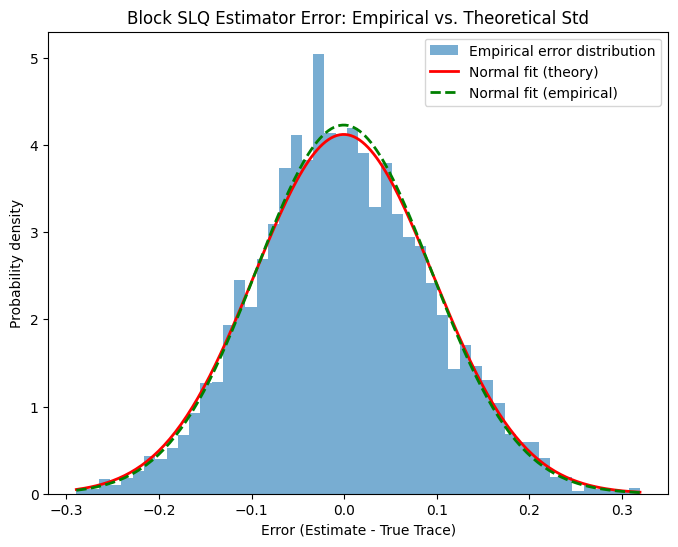

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Helper Functions (as defined earlier) ---

def generate_kernel_matrix(n, sigma=2.0):
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j)**2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    d = n - j
    z = np.zeros(d)
    z[0] = 1.0
    for _ in range(max_iter):
        Y_band = Y[:, j:n]
        r = Y_band.dot(z)
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0]**2)
        delta = np.linalg.solve(H, -g)
        z += delta
        if np.linalg.norm(delta) < tol:
            break
    return z

def estimate_cholesky(Y, m, n):
    L_est = np.zeros((n, n))
    for j in range(n):
        z = newton_column(Y, m, j, n)
        L_est[j:, j] = z
    return L_est

def A_mv_block(V, Sigma, L_est):
    return L_est.T @ (Sigma @ (L_est @ V))

# --- Simplified Block SLQ Estimator for Simulation ---
# (For simulation we compute f(A) explicitly.)

def block_slq_estimator(Sigma, L_est, block_size):
    """
    For simulation purposes only: we compute A = L_est^T Sigma L_est explicitly,
    then compute f(A) = A - log(A) - I, and then use a random block V.
    """
    n = L_est.shape[0]
    # Generate random block V with orthonormal columns
    Z = np.random.choice([-1,1], size=(n, block_size)).astype(np.float64)
    Q, _ = np.linalg.qr(Z)

    # Compute A explicitly
    A = L_est.T @ (Sigma @ L_est)
    # Diagonalize A to compute f(A)
    eigvals, eigvecs = np.linalg.eigh(A)
    def f(x):
        return x - np.log(x) - 1.0
    fA = eigvecs @ np.diag(f(eigvals)) @ eigvecs.T

    # Block estimator: Y = tr(V^T f(A) V)
    Y = np.trace(Q.T @ fA @ Q)
    # Unbiased estimator: scale by (n/block_size)
    return (n/block_size)*Y

# --- Simulation to compare empirical variance with theory ---
np.random.seed(42)
n = 200
m_samples = 10000
Sigma = generate_kernel_matrix(n, sigma=2.0)
mean_vec = np.zeros(n)
Y_samples = np.random.multivariate_normal(mean_vec, Sigma, size=m_samples)
L_est = estimate_cholesky(Y_samples, m_samples, n)

# Compute the true trace via full eigen-decomposition:
A = L_est.T @ (Sigma @ L_est)
eigvals, _ = np.linalg.eigh(A)
def f(x):
    return x - np.log(x) - 1.0
true_trace = np.sum(f(eigvals))
print("True trace of f(A):", true_trace)

# Monte Carlo simulation of block SLQ estimates:
num_trials = 5000
block_size = 5
b = block_size
estimates = np.array([block_slq_estimator(Sigma, L_est, block_size) for _ in range(num_trials)])

# Empirical variance (of the estimator X)
empirical_mean = np.mean(estimates)
empirical_var = np.var(estimates, ddof=1)
empirical_std = np.sqrt(empirical_var)
print("Empirical mean:", empirical_mean)
print("Empirical variance:", empirical_var)
print("Empirical std:", empirical_std)

# The theoretical variance, according to our derivation, is:
# Var(X) = (2n/(b(n+2)))[||f(A)||_F^2 - (tr(f(A)))^2/n]((b - b(b-1)/(n-1))/b)
fA = eigvecs @ np.diag(f(eigvals)) @ eigvecs.T  # but we already computed fA above
norm_fA_F2 = np.sum(f(eigvals)**2)  # since the Frobenius norm is invariant under orthogonal transform
theo_var = (2*n/(block_size*(n+2)))*(norm_fA_F2 - (true_trace**2)/n)*((b - b*(b-1)/(n-1))/b)
theo_std = np.sqrt(theo_var)
print("Theoretical variance:", theo_var)
print("Theoretical std:", theo_std)

# Plot the error distribution.
errors = estimates - true_trace
plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, density=True, alpha=0.6, label="Empirical error distribution")
x_vals = np.linspace(errors.min(), errors.max(), 200)
pdf_theo = norm.pdf(x_vals, loc=np.mean(errors), scale=theo_std)
plt.plot(x_vals, pdf_theo, 'r-', linewidth=2, label="Normal fit (theory)")
pdf_emp = norm.pdf(x_vals, loc=np.mean(errors), scale=empirical_std)
plt.plot(x_vals, pdf_emp, 'g--', linewidth=2, label="Normal fit (empirical)")
plt.xlabel("Error (Estimate - True Trace)")
plt.ylabel("Probability density")
plt.title("Block SLQ Estimator Error: Empirical vs. Theoretical Std")
plt.legend()
plt.show()


## Local Subblock SLQ

Probability that a random 51x51 subblock is full rank: 0.000


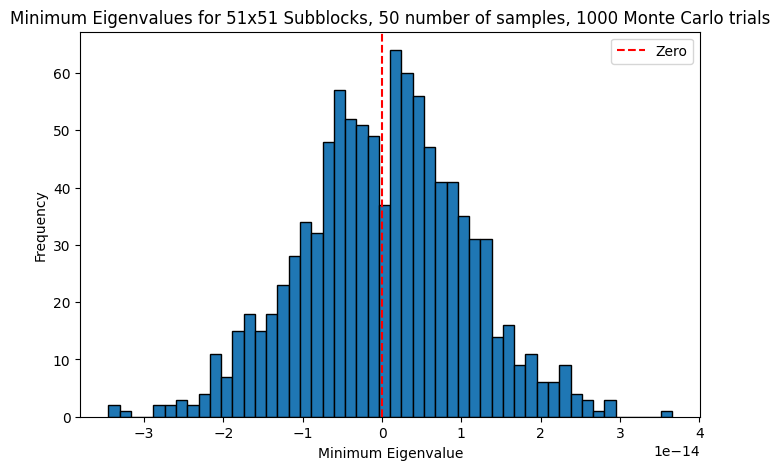

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_full_rank_subblock(n=200, m=50, s=30, iterations=1000, tol=1e-8):
    """
    Simulates the formation of A = L^T L with L drawn from i.i.d. Gaussian entries
    (representing sub-Gaussian random variables) and checks the full rank property for
    randomly selected s x s principal subblocks of A.

    Parameters:
      n : int
          Size of the covariance matrix A (n x n).
      m : int
          Sample size (number of rows in L); note that m << n.
      s : int
          Size of the subblock (s x s) to be examined; we require s <= m.
      iterations : int
          Number of simulation runs.
      tol : float
          Tolerance for determining whether an eigenvalue is positive.

    Returns:
      probability : float
          The empirical probability that a random s x s subblock is full rank.
      min_eigenvalues : list of floats
          The minimum eigenvalues of the subblocks over the simulation runs.
    """
    count_full_rank = 0
    min_eigenvalues = []

    for _ in range(iterations):
        # Generate L: m x n with i.i.d. standard Gaussian entries
        L = np.random.randn(m, n)
        # Form A = L^T L (which is n x n and has rank at most m)
        A = L.T @ L
        # print('Det of A:', np.linalg.det(A))

        # Randomly choose s indices out of n (the indices for the subblock)
        indices = np.sort(np.random.choice(n, s, replace=False))
        # Extract the s x s principal submatrix A_S corresponding to these indices
        A_S = A[np.ix_(indices, indices)]

        # Compute eigenvalues of the submatrix
        eigvals = np.linalg.eigvalsh(A_S)
        min_eig = np.min(eigvals)
        min_eigenvalues.append(min_eig)

        # Determine the numerical rank by counting eigenvalues above a tolerance
        rank = np.sum(eigvals > tol)
        if rank == s:
            count_full_rank += 1

    probability = count_full_rank / iterations
    return probability, min_eigenvalues

if __name__ == "__main__":
    # Parameters: choose n, m, and s so that s <= m and m << n.
    n = 200     # Total dimension of the covariance matrix
    m = 50      # Number of samples (effective rank is at most m)
    s = 51      # Subblock size (ensure s <= m)
    iterations = 1000   # Number of trials for the simulation

    prob, min_eigs = simulate_full_rank_subblock(n=n, m=m, s=s, iterations=iterations)
    print(f"Probability that a random {s}x{s} subblock is full rank: {prob:.3f}")

    # Plot a histogram of the minimum eigenvalues of the s x s subblocks.
    plt.figure(figsize=(8, 5))
    plt.hist(min_eigs, bins=50, edgecolor='black')
    plt.title(f"Minimum Eigenvalues for {s}x{s} Subblocks, {m} number of samples, 1000 Monte Carlo trials")
    plt.xlabel("Minimum Eigenvalue")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label="Zero")
    plt.legend()
    # plt.savefig('subblockeigs2.png', dpi=300)
    plt.show()


Probability that a random 30x30 subblock is full rank: 1.000


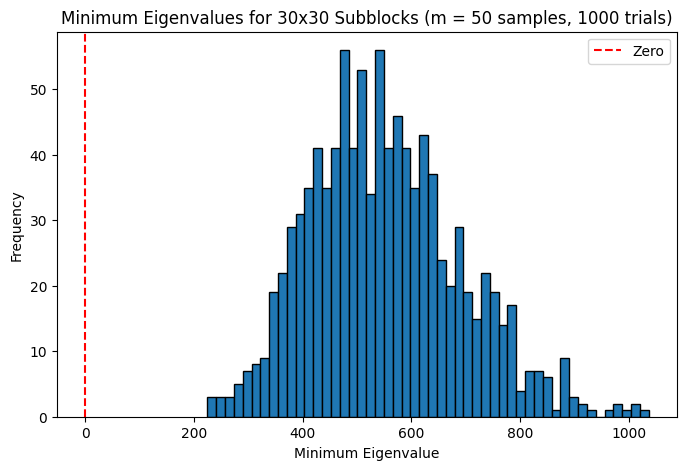

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_full_rank_subblock_sig(n, m, s, iterations=1000, tol=1e-8):
    """
    Simulates the formation of A = L^T Σ L, where:
      - Σ is the covariance matrix computed as Σ = ∑_{i=1}^m x_i x_i^T = X X^T,
        with X an n x m matrix whose columns x_i are independent samples in ℝⁿ.
      - L is an independent n x m matrix with i.i.d. standard Gaussian (sub-Gaussian) entries.

    The matrix A is of size m x m. We then examine a random s x s principal submatrix A_S of A
    (with s <= m) by checking its minimum eigenvalue. If the minimum eigenvalue is positive
    (up to a tolerance), then A_S is considered full rank.

    Parameters:
      n : int
          Ambient dimension, i.e. each sample x_i ∈ ℝⁿ.
      m : int
          Number of samples (and thus the number of columns in X and L). Typically m << n.
      s : int
          Size of the principal subblock (s x s) to be examined; require s ≤ m.
      iterations : int
          Number of simulation runs.
      tol : float
          Tolerance used to determine if an eigenvalue is positive.

    Returns:
      probability : float
          The empirical probability that a random s x s subblock is full rank.
      min_eigenvalues : list of floats
          The minimum eigenvalues of the subblocks over the simulation runs.
    """

    count_full_rank = 0
    min_eigenvalues = []

    for _ in range(iterations):
        # Generate X: n x m matrix; each column is an independent sample in ℝⁿ.
        X = np.random.randn(n, m)
        # Compute the covariance matrix: Σ = sum_{i=1}^m x_i x_i^T = X X^T.
        Sigma = X @ X.T

        # Generate L: an independent n x m matrix with i.i.d. sub-Gaussian (standard Gaussian) entries.
        L = np.random.randn(n, m)

        # Form A = L^T Σ L; A is an m x m matrix.
        A = L.T @ Sigma @ L

        # Randomly choose s indices out of the available m indices for the principal submatrix.
        indices = np.sort(np.random.choice(m, s, replace=False))
        # Extract the s x s principal submatrix A_S corresponding to these indices.
        A_S = A[np.ix_(indices, indices)]

        # Compute the eigenvalues of A_S.
        eigvals = np.linalg.eigvalsh(A_S)
        min_eig = np.min(eigvals)
        min_eigenvalues.append(min_eig)

        # Check for numerical full rank (all eigenvalues greater than tolerance).
        rank = np.sum(eigvals > tol)
        if rank == s:
            count_full_rank += 1

    probability = count_full_rank / iterations
    return probability, min_eigenvalues

if __name__ == "__main__":
    # Parameters: n is the ambient dimension, m is the number of samples,
    # and s (subblock size) must satisfy s <= m.
    n = 200     # Ambient dimension (ℝⁿ)
    m = 50      # Number of samples
    s = 30      # Size of the principal subblock (s x s) to be analyzed
    iterations = 1000   # Number of Monte Carlo simulation trials

    prob, min_eigs = simulate_full_rank_subblock_sig(n=n, m=m, s=s, iterations=iterations)
    print(f"Probability that a random {s}x{s} subblock is full rank: {prob:.3f}")

    # Plot a histogram of the minimum eigenvalues of the s x s subblocks.
    plt.figure(figsize=(8, 5))
    plt.hist(min_eigs, bins=50, edgecolor='black')
    plt.title(f"Minimum Eigenvalues for {s}x{s} Subblocks (m = {m} samples, {iterations} trials)")
    plt.xlabel("Minimum Eigenvalue")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label="Zero")
    plt.legend()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # import the progress bar library

def generate_kernel_matrix(n, sigma=2.0):
    """
    Generate a positive-definite n x n kernel matrix using a Gaussian kernel.
    """
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    """
    Estimate the j-th column (rows j:n) of the Cholesky factor using Newton's method.
    """
    d = n - j
    z = np.zeros(d)
    z[0] = 1.0  # initialize the diagonal
    for _ in range(max_iter):
        Y_band = Y[:, j:n]
        r = Y_band.dot(z)
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0] ** 2)
        delta = np.linalg.solve(H, -g)
        z += delta
        if np.linalg.norm(delta) < tol:
            break
    return z

def estimate_cholesky(Y, m, n):
    """
    Estimate the full lower-triangular Cholesky factor L (n x n) column-by-column.
    """
    L_est = np.zeros((n, n))
    for j in range(n):
        z = newton_column(Y, m, j, n)
        L_est[j:, j] = z
    return L_est

def kl_divergence_direct(Sigma, L_est):
    """
    Directly compute the KL divergence via:
    KL = 0.5 [ tr(L_est L_est^T Sigma) - logdet(L_est L_est^T Sigma) - n ].
    """
    n = Sigma.shape[0]
    M = L_est @ L_est.T @ Sigma
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * (np.trace(M) - logdet - n)

def A_mv(v, Sigma, L_est):
    """
    Compute A*v = L_est^T [ Sigma (L_est * v) ].
    Only one mat-vec with Sigma is performed.
    """
    return L_est.T @ (Sigma @ (L_est @ v))

def lanczos(A_mv_func, v, k, Sigma, L_est):
    """
    Run Lanczos algorithm for k iterations on the symmetric operator A (via A_mv_func).
    Returns the k x k tridiagonal matrix T.
    """
    n = len(v)
    Q = np.zeros((n, k))
    alpha = np.zeros(k)
    beta = np.zeros(k + 1)
    Q[:, 0] = v
    for j in range(k):
        w = A_mv_func(Q[:, j], Sigma, L_est)
        if j > 0:
            w -= beta[j] * Q[:, j - 1]
        alpha[j] = np.dot(Q[:, j], w)
        w -= alpha[j] * Q[:, j]
        beta[j + 1] = np.linalg.norm(w)
        if beta[j + 1] < 1e-12 or j == k - 1:
            k_actual = j + 1
            alpha = alpha[:k_actual]
            beta = beta[:k_actual + 1]
            Q = Q[:, :k_actual]
            break
        Q[:, j + 1] = w / beta[j + 1]
        k_actual = k
    T = np.diag(alpha)
    for i in range(k_actual - 1):
        T[i, i + 1] = beta[i + 1]
        T[i + 1, i] = beta[i + 1]
    return T

def randomized_kl_divergence(Sigma, L_est, num_probes=20, lanczos_steps=30):
    """
    Estimate the KL divergence using stochastic Lanczos quadrature (SLQ).
    f(λ) = λ - log(λ) - 1, and KL = 0.5 * trace(f(A)),
    where A = L_est^T Sigma L_est.
    """
    def f(x):
        return x - np.log(x) - 1.0

    n = L_est.shape[0]
    estimates = []
    for _ in range(num_probes):
        z = np.random.choice([-1, 1], size=n).astype(np.float64)
        v = z / np.linalg.norm(z)
        T = lanczos(A_mv, v, lanczos_steps, Sigma, L_est)
        eigvals, U = np.linalg.eigh(T)
        estimate = n * np.sum((U[0, :] ** 2) * f(eigvals))
        estimates.append(estimate)
    trace_estimate = np.mean(estimates)
    return 0.5 * trace_estimate

# ---------------------------
# Timing study: larger dimensions and averaging over multiple repeats
# ---------------------------
dimensions = [50, 100, 200, 400, 800, 1600, 3200, 6400]
# dimensions = [50, 100, 200, 400, 800]
m = 5000   # Number of samples
repeats = 5  # Number of repeats to average timings

direct_times = []
random_times = []

# Loop over dimensions with a progress bar
for n in tqdm(dimensions, desc="Processing dimensions"):
    direct_time_sum = 0.0
    random_time_sum = 0.0
    # Loop over repeats with a nested progress bar
    for _ in tqdm(range(repeats), desc="Repeats", leave=False):
        # Generate covariance and samples
        Sigma = generate_kernel_matrix(n, sigma=2.0)
        mean = np.zeros(n)
        Y = np.random.multivariate_normal(mean, Sigma, size=m)
        L_est = estimate_cholesky(Y, m, n)

        # Time direct KL divergence computation
        start = time.time()
        _ = kl_divergence_direct(Sigma, L_est)
        direct_time_sum += (time.time() - start)

        # Time randomized SLQ KL divergence estimation
        start = time.time()
        _ = randomized_kl_divergence(Sigma, L_est, num_probes=20, lanczos_steps=30)
        random_time_sum += (time.time() - start)

    direct_times.append(direct_time_sum / repeats)
    random_times.append(random_time_sum / repeats)

# Create a log-log plot for the timing results
plt.figure(figsize=(8, 6))
plt.loglog(dimensions, direct_times, marker='o', label='Direct Computation')
plt.loglog(dimensions, random_times, marker='s', label='Randomized SLQ')
plt.xlabel("Dimension n")
plt.ylabel("Time (seconds, averaged)")
plt.title("Timing Comparison: Direct vs Randomized SLQ for KL Divergence")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Processing dimensions:  75%|███████▌  | 6/8 [9:19:14<3:06:24, 5592.47s/it]


KeyboardInterrupt: 

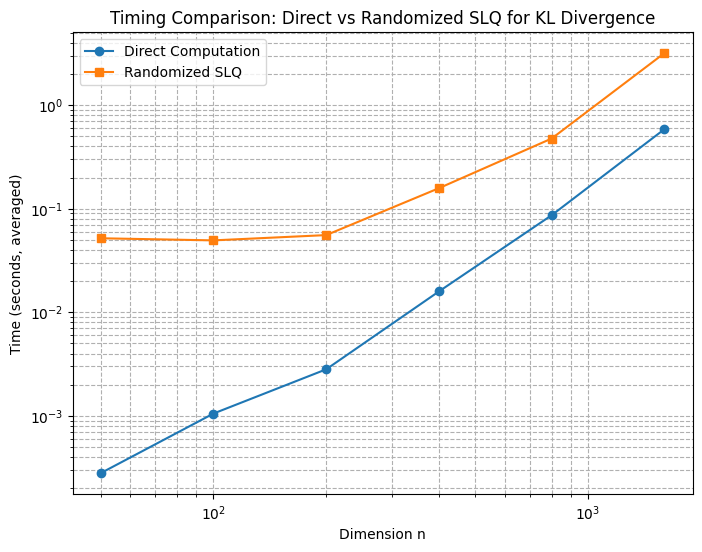

In [ ]:
# Create a log-log plot for the timing results
plt.figure(figsize=(8, 6))
plt.loglog(dimensions[:-2], direct_times, marker='o', label='Direct Computation')
plt.loglog(dimensions[:-2], random_times, marker='s', label='Randomized SLQ')
plt.xlabel("Dimension n")
plt.ylabel("Time (seconds, averaged)")
plt.title("Timing Comparison: Direct vs Randomized SLQ for KL Divergence")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

KL divergence (direct computation): 410.2016532398574


Varying Lanczos Steps: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


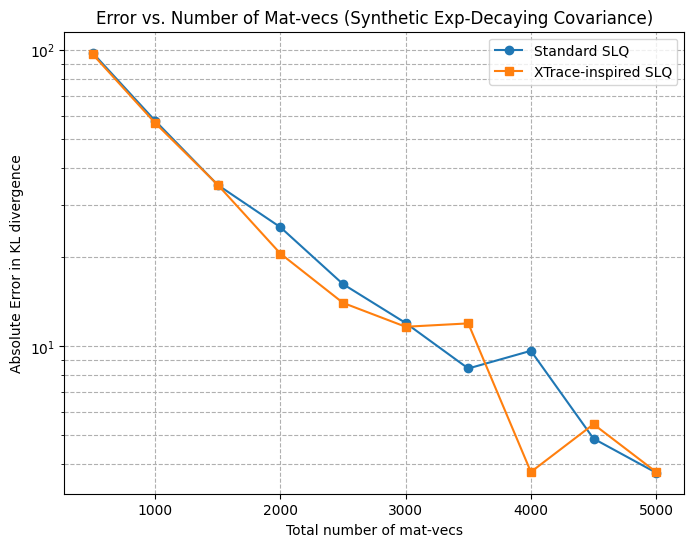

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# Helper functions from before
# ---------------------------
def generate_exponential_covariance(n, decay=5.0):
    """
    Create a synthetic covariance matrix with exponentially decaying eigenvalues.
    The eigenvalues are defined as exp(-linspace(0, decay, n)).
    """
    # Create exponentially decaying eigenvalues
    eigvals = np.exp(-np.linspace(0, decay, n))
    # Generate a random orthonormal matrix U via QR decomposition
    U, _ = np.linalg.qr(np.random.randn(n, n))
    # Form Sigma = U diag(eigvals) U^T (symmetric positive definite)
    Sigma = U @ np.diag(eigvals) @ U.T
    return Sigma

def kl_divergence_direct(Sigma, L):
    """
    Compute the KL divergence directly:
    KL = 0.5 * [ trace(L L^T Sigma) - logdet(L L^T Sigma) - n ].
    When L is the exact Cholesky factor of Sigma, L L^T = Sigma.
    """
    n = Sigma.shape[0]
    M = L @ L.T @ Sigma
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * (np.trace(M) - logdet - n)

def A_mv(v, Sigma, L):
    """
    Compute A*v = L^T [ Sigma (L * v) ].
    (Here L is assumed to be given exactly.)
    """
    return L.T @ (Sigma @ (L @ v))

def lanczos(A_mv_func, v, k, Sigma, L):
    """
    Run the Lanczos algorithm for k steps on the symmetric operator A (accessed via A_mv_func).
    Returns the k x k tridiagonal matrix T.
    """
    n = len(v)
    Q = np.zeros((n, k))
    alpha = np.zeros(k)
    beta = np.zeros(k + 1)
    Q[:, 0] = v
    for j in range(k):
        w = A_mv_func(Q[:, j], Sigma, L)
        if j > 0:
            w -= beta[j] * Q[:, j - 1]
        alpha[j] = np.dot(Q[:, j], w)
        w -= alpha[j] * Q[:, j]
        beta[j + 1] = np.linalg.norm(w)
        if beta[j + 1] < 1e-12 or j == k - 1:
            k_actual = j + 1
            alpha = alpha[:k_actual]
            beta = beta[:k_actual + 1]
            Q = Q[:, :k_actual]
            break
        Q[:, j + 1] = w / beta[j + 1]
        k_actual = k
    # Construct the symmetric tridiagonal matrix T from alpha and beta[1:k_actual]
    T = np.diag(alpha)
    for i in range(k_actual - 1):
        T[i, i + 1] = beta[i + 1]
        T[i + 1, i] = beta[i + 1]
    return T

def randomized_kl_divergence(Sigma, L, num_probes=20, lanczos_steps=20):
    """
    Standard SLQ estimator for the KL divergence.
    f(x) = x - log(x) - 1, and KL = 0.5 * trace(f(A)),
    where A = L^T Sigma L.
    """
    def f(x):
        return x - np.log(x) - 1.0

    n = L.shape[0]
    estimates = []
    for _ in range(num_probes):
        # Use a Rademacher random vector
        z = np.random.choice([-1, 1], size=n).astype(np.float64)
        v = z / np.linalg.norm(z)
        T = lanczos(A_mv, v, lanczos_steps, Sigma, L)
        eigvals, U = np.linalg.eigh(T)
        # Quadrature: e1^T f(T) e1 weighted by n
        estimate = n * np.sum((U[0, :] ** 2) * f(eigvals))
        estimates.append(estimate)
    trace_estimate = np.mean(estimates)
    return 0.5 * trace_estimate

def randomized_kl_divergence_xtrace(Sigma, L, num_probes=20, lanczos_steps=20):
    """
    XTrace-inspired SLQ estimator.
    Computes an estimate from each probe, then averages.
    Also returns the sample standard deviation as an error indicator.
    """
    def f(x):
        return x - np.log(x) - 1.0

    n = L.shape[0]
    estimates = []
    for _ in tqdm(range(num_probes), desc="XTrace SLQ Probes"):
        z = np.random.choice([-1, 1], size=n).astype(np.float64)
        v = z / np.linalg.norm(z)
        T = lanczos(A_mv, v, lanczos_steps, Sigma, L)
        eigvals, U = np.linalg.eigh(T)
        est = n * np.sum((U[0, :] ** 2) * f(eigvals))
        estimates.append(est)
    estimates = np.array(estimates)
    trace_estimate = np.mean(estimates)
    error_estimate = np.std(estimates, ddof=1)
    return 0.5 * trace_estimate, 0.5 * error_estimate

# ---------------------------
# Main simulation on new synthetic problem
# ---------------------------
np.random.seed(42)
n = 200

# Create a synthetic covariance matrix with exponential eigenvalue decay.
Sigma = generate_exponential_covariance(n, decay=5.0)

# Compute the exact Cholesky factor of Sigma (no estimation error here).
L_exact = np.linalg.cholesky(Sigma)

# Compute the "ground truth" KL divergence using direct computation.
kl_direct = kl_divergence_direct(Sigma, L_exact)
print("KL divergence (direct computation):", kl_direct)

# Parameters for the SLQ experiments.
num_probes = 100
# We vary the number of Lanczos steps to see how the error decreases.
lanczos_steps_list = np.arange(5, 55, 5)
errors_standard = []
errors_xtrace = []
matvec_counts = []  # total number of mat-vecs = num_probes * lanczos_steps

# Loop over different numbers of Lanczos steps.
for k in tqdm(lanczos_steps_list, desc="Varying Lanczos Steps"):
    # Standard randomized SLQ estimator.
    kl_est_std = randomized_kl_divergence(Sigma, L_exact, num_probes=num_probes, lanczos_steps=k)
    # XTrace-inspired estimator (returns error estimate too).
    kl_est_xt, err_xt = randomized_kl_divergence_xtrace(Sigma, L_exact, num_probes=num_probes, lanczos_steps=k)

    # Compute absolute errors with respect to the direct KL divergence.
    error_std = abs(kl_est_std - kl_direct)
    error_xt = abs(kl_est_xt - kl_direct)

    errors_standard.append(error_std)
    errors_xtrace.append(error_xt)
    # Each probe uses k mat-vecs.
    matvec_counts.append(num_probes * k)

# Plot the absolute error versus total number of mat-vecs on a semilogy scale.
plt.figure(figsize=(8, 6))
plt.semilogy(matvec_counts, errors_standard, 'o-', label="Standard SLQ")
plt.semilogy(matvec_counts, errors_xtrace, 's-', label="XTrace-inspired SLQ")
plt.xlabel("Total number of mat-vecs")
plt.ylabel("Absolute Error in KL divergence")
plt.title("Error vs. Number of Mat-vecs (Synthetic Exp-Decaying Covariance)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


## Identifying sparsity pattern from data (old MLE)


Theta_est for complexity 1 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   4.976149e-01 -1.322293e-14 -7.794396e-15  8.358530e-15 -5.984457e-15   
Row 1  -1.322293e-14  2.660575e-01  1.081632e-13 -7.201129e-14  4.644174e-14   
Row 2  -7.794396e-15  1.081632e-13  2.178091e-01  1.311902e-13 -8.928537e-14   
Row 3   8.358530e-15 -7.201129e-14  1.311902e-13  1.986322e-01  1.506019e-13   
Row 4  -5.984457e-15  4.644174e-14 -8.928537e-14  1.506019e-13  1.936294e-01   
Row 5   3.829067e-15 -2.803108e-14  5.579948e-14 -9.931381e-14  1.571576e-13   
Row 6  -2.258214e-15  1.663781e-14 -3.517669e-14  6.251057e-14 -1.064809e-13   
Row 7   1.474289e-15 -1.033965e-14  2.196462e-14 -3.838650e-14  6.615510e-14   
Row 8  -8.487277e-16  6.002161e-15 -1.383616e-14  2.318696e-14 -4.025336e-14   
Row 9   5.205924e-16 -5.118406e-15  9.374224e-15 -1.396766e-14  2.489179e-14   
Row 10 -1.150419e-15  7.180848e-15 -8.686594e-15  1.024730e-14 -1.

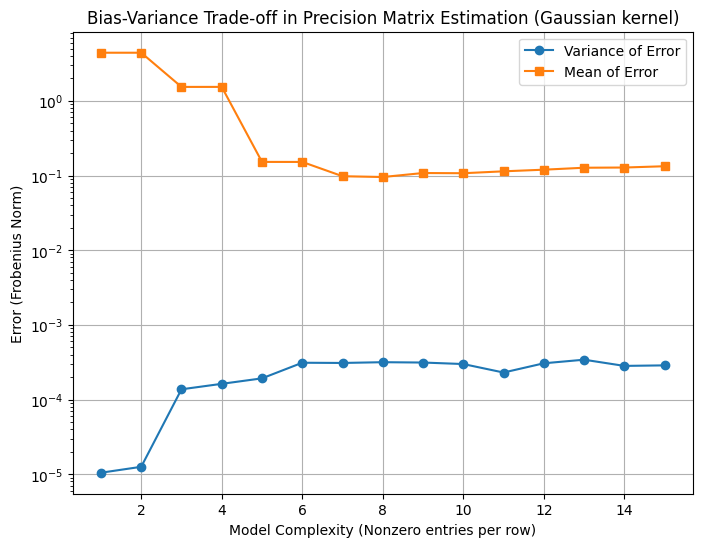

true_theta = 
               0             1             2             3             4   \
0   1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02  3.354626e-04   
1   6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01  1.110900e-02   
2   1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01  1.353353e-01   
3   1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00  6.065307e-01   
4   3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01  1.000000e+00   
5   3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01  6.065307e-01   
6   1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02  1.353353e-01   
7   2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04  1.110900e-02   
8   1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06  3.354626e-04   
9   2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08  3.726653e-06   
10  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11  1.522998e-08   
11  5.311092e-27  1.928750e-22  2.576757e-18  1.266417e-14  2.289735e-11 

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

def generate_kernel_matrix(n, sigma=2.0):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A


def generate_l_diagonal_matrix(n, l, diag_mean=-2, diag_std=0.5, offdiag_mean=1, offdiag_std=0.2):
    """
    Generate a random l-diagonal symmetric positive definite precision matrix of size n x n.
    """
    matrix = np.zeros((n, n))
    main_diag = np.random.normal(diag_mean, diag_std, n)
    np.fill_diagonal(matrix, main_diag)
    for band in range(1, l):
        off_diag = np.random.normal(offdiag_mean, offdiag_std, n - band)
        matrix += np.diag(off_diag, k=band) + np.diag(off_diag, k=-band)
    min_eig = np.min(np.linalg.eigvalsh(matrix))
    if min_eig <= 0:
        matrix += np.eye(n) * (0.1 - min_eig)
    return matrix

def create_sparsity_pattern(n, k):
    """
    Create a sparsity pattern with k nonzero entries per row from the diagonal outward.
    """
    sparsity_pattern = []
    half_bandwidth = (k - 1) // 2
    for i in range(n):
        indices = [i]
        for band in range(1, half_bandwidth + 1):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15  # Matrix size
l = 5   # Half-bandwidth (5 lower + 5 upper diagonals = 9-diagonal matrix)
# true_theta = generate_l_diagonal_matrix(n, l)
true_theta = generate_kernel_matrix(n, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 10000   #number of samples
complexities = range(1, n + 1)

variance_list = []
mean_error_list = []

for k in complexities:
    errors = []
    sparsity_pattern = create_sparsity_pattern(n, k)
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    Theta_est_df = pd.DataFrame(Theta_est, columns=[f"Col {i}" for i in range(n)], index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per row:\n")
    print(Theta_est_df)
    is_valid = all(np.abs(Theta_est[i, j]) < 1e-8 for i in range(n) for j in range(n) if j not in sparsity_pattern[i])
    print(f"Constraints satisfied for complexity {k}: {is_valid}\n")
    variance_list.append(np.var(errors))
    mean_error_list.append(np.mean(errors))

plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per row)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation (Gaussian kernel)")

plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))


<ipython-input-2-ca252dbc25d5>:20: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return sigma**2 * (2**(1 - nu) / np.math.gamma(nu)) * (factor**nu) * kv(nu, factor)



Theta_est for complexity 1 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   3.542320e+00  3.387164e-11 -3.088275e-11  1.786864e-11 -1.027643e-11   
Row 1   3.387164e-11  3.140080e+00  5.732675e-11 -2.822286e-11  9.964345e-12   
Row 2  -3.088275e-11  5.732675e-11  2.436325e+00  6.405698e-11 -4.445649e-11   
Row 3   1.786864e-11 -2.822286e-11  6.405698e-11  3.267277e+00  3.381766e-11   
Row 4  -1.027643e-11  9.964345e-12 -4.445649e-11  3.381766e-11  2.317773e+00   
Row 5  -8.633436e-13  1.006293e-11  1.238677e-11 -3.205148e-12  5.857218e-11   
Row 6  -8.855495e-14  3.736988e-12 -6.158576e-12  5.592560e-12 -6.248261e-12   
Row 7  -9.464988e-12  1.462005e-11  6.070152e-12  8.014073e-12  1.955101e-12   
Row 8   3.187848e-13 -1.113239e-11 -8.342952e-12  1.271129e-11  4.501935e-12   
Row 9   1.483881e-12 -1.422150e-11  8.983343e-12 -1.412516e-11 -8.653017e-12   
Row 10  4.202355e-12  1.897776e-11 -2.424065e-11  1.119236e-11 -1.

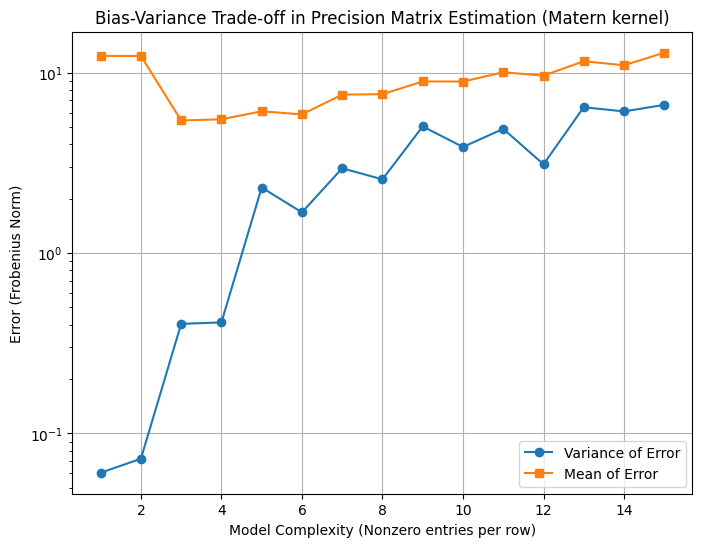

true_theta = 
               0             1             2             3         4   \
0   4.000000e+00  1.933431e+00  5.589254e-01  1.372530e-01  0.031071   
1   1.933431e+00  4.000000e+00  1.933431e+00  5.589254e-01  0.137253   
2   5.589254e-01  1.933431e+00  4.000000e+00  1.933431e+00  0.558925   
3   1.372530e-01  5.589254e-01  1.933431e+00  4.000000e+00  1.933431   
4   3.107094e-02  1.372530e-01  5.589254e-01  1.933431e+00  4.000000   
5   6.698044e-03  3.107094e-02  1.372530e-01  5.589254e-01  1.933431   
6   1.397497e-03  6.698044e-03  3.107094e-02  1.372530e-01  0.558925   
7   2.848375e-04  1.397497e-03  6.698044e-03  3.107094e-02  0.137253   
8   5.704438e-05  2.848375e-04  1.397497e-03  6.698044e-03  0.031071   
9   1.126899e-05  5.704438e-05  2.848375e-04  1.397497e-03  0.006698   
10  2.201894e-06  1.126899e-05  5.704438e-05  2.848375e-04  0.001397   
11  4.263916e-07  2.201894e-06  1.126899e-05  5.704438e-05  0.000285   
12  8.195368e-08  4.263916e-07  2.201894e-06  1.1

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.special import kv  # Modified Bessel function of the second kind

def matern_kernel(d, nu=1.5, l=1.0, sigma=2.0):
    """
    Matérn kernel function.
    d : distance matrix
    nu : smoothness parameter
    l : length scale
    sigma : variance parameter
    """
    if d == 0.0:
        return sigma**2
    factor = np.sqrt(2 * nu) * d / l
    return sigma**2 * (2**(1 - nu) / np.math.gamma(nu)) * (factor**nu) * kv(nu, factor)

def generate_matern_kernel_matrix(n, nu=1.5, l=1.0, sigma=2.0):
    """
    Generate an n x n Matérn kernel matrix.
    """
    # Generate distances
    x = np.arange(n).reshape(-1, 1)
    dists = squareform(pdist(x, 'euclidean'))

    A = np.vectorize(lambda d: matern_kernel(d, nu, l, sigma))(dists)

    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A


def create_sparsity_pattern(n, k):
    """
    Create a sparsity pattern with k nonzero entries per row from the diagonal outward.
    """
    sparsity_pattern = []
    half_bandwidth = (k - 1) // 2
    for i in range(n):
        indices = [i]
        for band in range(1, half_bandwidth + 1):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15  # Matrix size
l = 5   # Half-bandwidth (5 lower + 5 upper diagonals = 9-diagonal matrix)
# true_theta = generate_l_diagonal_matrix(n, l)
true_theta = generate_matern_kernel_matrix(n, nu=1.5, l=1.0, sigma=2.0)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 50
complexities = range(1, n + 1)

variance_list = []
mean_error_list = []

for k in complexities:
    errors = []
    sparsity_pattern = create_sparsity_pattern(n, k)
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    Theta_est_df = pd.DataFrame(Theta_est, columns=[f"Col {i}" for i in range(n)], index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per row:\n")
    print(Theta_est_df)
    is_valid = all(np.abs(Theta_est[i, j]) < 1e-8 for i in range(n) for j in range(n) if j not in sparsity_pattern[i])
    print(f"Constraints satisfied for complexity {k}: {is_valid}\n")
    variance_list.append(np.var(errors))
    mean_error_list.append(np.mean(errors))

plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per row)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation (Matern kernel)")

plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))

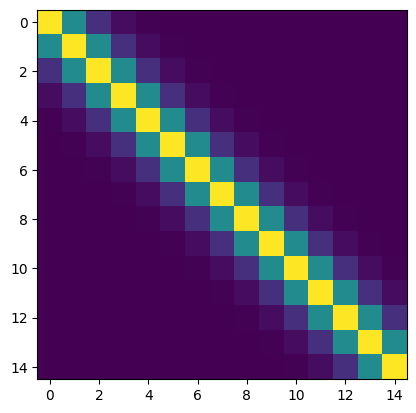

In [ ]:
plt.imshow(true_theta)